###### Università degli Studi di Milano, Data Science and Economics Master Degree

# Introduction to gymnasium

### Alfio Ferrara

[Gymnasium](https://gymnasium.farama.org/), formerly knwown as `gym`, is Python library for reinforcement learning.

The main idea of `gym` is to provide a easy and highly customizable dev framework for creating MDPs as `environments` in which agents can be trained. Thus, `gym` **does not** provide pre-defined algorithms or agents, but mainly a modeling tool for building MDPs and Agents.

## The `gym` main concepts

### Environments
An environment is a python class that serves as an environment for an agent. Let's see an example:

In [3]:
import numpy as np
import gymnasium as gym

In [4]:
env = gym.make('FrozenLake-v1', render_mode=None)
observation, info = env.reset()

end_episode = False 
while not end_episode:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    end_episode = terminated or truncated
env.close()

#### Rendering
Many pre-defined environments in `gym` support one or more rendering modes. Those depends sometimes on external libraries or `gym` type of environments. The following are the main ones:

##### [Classic Control](https://gymnasium.farama.org/environments/classic_control/)
This needs:
```
pip install gymnasium[classic-control]
```
##### [Box2D](https://gymnasium.farama.org/environments/box2d/)
These environments all involve toy games based around physics control and exploits `PyGame`
```
pip install swig
pip install gymnasium[box2d]
```
##### [ToyText](https://gymnasium.farama.org/environments/toy_text/)
Toy text environments are designed to be extremely simple, with small discrete state and action spaces, and hence easy to learn.
```
no special requirements
```
##### [MuJoCo (Multi-Joint dynamics with Contact)](https://gymnasium.farama.org/environments/mujoco/)
Robots in physical environments
```
pip install gymnasium[mujoco]
```
##### [Atari](https://ale.farama.org/environments/)
Atari ROM emulators
```
pip install ale-py
import gymnasium as gym
import ale_py

gym.register_envs(ale_py)

env = gym.make('ALE/Breakout-v5')
obs, info = env.reset()
obs, reward, terminated, truncated, info = env.step(env.action_space.sample())
env.close()
```
##### [Other environments](https://gymnasium.farama.org/environments/third_party_environments/)
Several domain specific environments.



### Issues about rendering
Rendering in `human` mode may cause problems with notebooks. A simple workaround is to include the environment in a python class. (see [./gymbase/rendering.py](./gymbase/rendering.py))

As an alternative, you can just render a frame at time, as in the following example.

See later, on how to record a video of the episode instead.

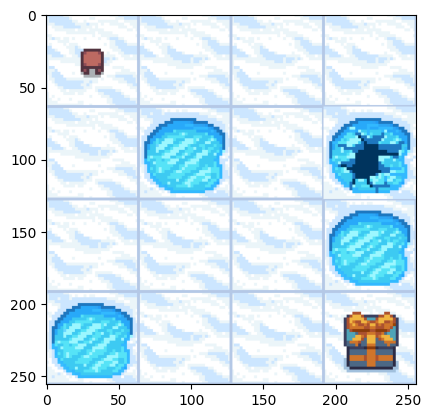

In [5]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import time

env = gym.make('FrozenLake-v1', render_mode='rgb_array')
observation, info = env.reset()

end_episode = False 
while not end_episode:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    end_episode = terminated or truncated
    clear_output(wait=True)
    plt.imshow(env.render())
    plt.show()
    time.sleep(.5)
env.close()


### Anatomy of an environment
A `gym` environment provides the functions needed to implement a single interaction between an agent and the MDP, according to the following scheme:
1. the **Agent** start a new episode using `env.reset()`
2. the **Agent** chooses an **action** from the `env.action_space` according to the Agent **policy**
3. the **Agent** executes the **action** through the `env.step()` function
4. the **Agent** reads the new state in form of an **observation** and collects a **reward** as return values of the `env.step()` function, which returns also information about the interaction end, variables `terminated` or `truncated`, and, optionally, some further **info**.
5. if not `terminated` or `truncated`, points 2-4 are repeated.
6. the **Agent** closes the episode using `env.close()`

![](./imgs/gymenv.png)

Let's see how the `environment` concepts corresponds to the structure of a MDP:

- **states**: `env.observation_space` (see below for the notion of `space` in `gym`). The next state is returned by the `env.step(action)` function. The current state is hidden within the `env` object: `gym` environments are conceived mainly for `model-free` interactions, not for exploring the environment space state by state. 
- **actions**: `env.action_space`  (see below for the notion of `space` in `gym`)
- **reward**: a `float` value returned by the `env.step(action)` function
- **termination**: `terminated` or `truncated` variables returned by the `env.step(action)`
- **transition probability**: `env.unwrapped.P` (see below for the notion of `wrapper` in `gym`)

#### Transition probabilities
Transition probabilities are retpresented through the `env.unwrapped.P` map in the following format:
```
state: {
    action: [P(s' | s, a), s', r, terminal_state (boolean)]
}
```

### Frozen Lake example

In the FrozenLake environment, the agent wants to cross a frozen lake from start to goal without falling into any holes by walking over the frozen lake. The player may not always move in the intended direction due to the slippery nature of the frozen lake.

`is_slippery=True`: If true the player will move in intended direction with probability of 1/3 else will move in either perpendicular direction with equal probability of 1/3 in both directions.

##### Actions
- 0: Move left
- 1: Move down
- 2: Move right
- 3: Move up

##### Space
The agent location in a grid, expressed as `current_row * ncols + current_col`. For example, the goal position in the 4x4 map can be calculated as follows: 3 * 4 + 3 = 15. The number of possible observations is dependent on the size of the map.

##### Reward
- Reach goal: +1
- Reach hole: 0
- Reach frozen: 0

The episode ends when the agent reaches the temrinal state or falls into a hole.

In [6]:
env = gym.make('FrozenLake-v1', render_mode=None, is_slippery=True)

In [7]:
probabilities = env.unwrapped.P
print(probabilities[14])

{0: [(0.3333333333333333, 10, 0.0, False), (0.3333333333333333, 13, 0.0, False), (0.3333333333333333, 14, 0.0, False)], 1: [(0.3333333333333333, 13, 0.0, False), (0.3333333333333333, 14, 0.0, False), (0.3333333333333333, 15, 1.0, True)], 2: [(0.3333333333333333, 14, 0.0, False), (0.3333333333333333, 15, 1.0, True), (0.3333333333333333, 10, 0.0, False)], 3: [(0.3333333333333333, 15, 1.0, True), (0.3333333333333333, 10, 0.0, False), (0.3333333333333333, 13, 0.0, False)]}


#### [env.reset()](https://gymnasium.farama.org/api/env/#gymnasium.Env.reset)

In [8]:
observation, info = env.reset()
print(f"Agent state: {observation:>10}")
print(f"Additional info: {str(info):>15}")

Agent state:          0
Additional info:     {'prob': 1}


#### [env.action_space](https://gymnasium.farama.org/api/env/#gymnasium.Env.action_space)
An action space is an instance of the class `Space`, which is used to represent both the action and the state spaces. `gym` support several kinds of different spaces:
- [Box](https://gymnasium.farama.org/api/spaces/fundamental/#gymnasium.spaces.Box): describes bounded space with upper and lower limits of any n-dimensional shape.
- [Discrete](https://gymnasium.farama.org/api/spaces/fundamental/#gymnasium.spaces.Discrete): describes a discrete space where {0, 1, ..., n-1} are the possible values our observation or action can take.
- [MultiBinary](https://gymnasium.farama.org/api/spaces/fundamental/#gymnasium.spaces.MultiBinary): describes a binary space of any n-dimensional shape.
- [MultiDiscrete](https://gymnasium.farama.org/api/spaces/fundamental/#gymnasium.spaces.MultiDiscrete): consists of a series of Discrete action spaces with a different number of actions in each element.
- [Text](https://gymnasium.farama.org/api/spaces/fundamental/#gymnasium.spaces.Text): describes a string space with a minimum and maximum length.
- [Dict](https://gymnasium.farama.org/api/spaces/composite/#gymnasium.spaces.Dict): describes a dictionary of simpler spaces.
- [Tuple](https://gymnasium.farama.org/api/spaces/composite/#gymnasium.spaces.Tuple): describes a tuple of simple spaces.
- [Graph](https://gymnasium.farama.org/api/spaces/composite/#gymnasium.spaces.Graph): describes a mathematical graph (network) with interlinking nodes and edges.
- [Sequence](https://gymnasium.farama.org/api/spaces/composite/#gymnasium.spaces.Sequence): describes a variable length of simpler space elements.

In [9]:
action_names = ["left", "down", "right", "up"]
for i in range(6):
    action = env.action_space.sample()
    print(f"Action {i}: {action:>5} => {action_names[action]}")

Action 0:     3 => up
Action 1:     0 => left
Action 2:     3 => up
Action 3:     1 => down
Action 4:     1 => down
Action 5:     3 => up


#### [env.step()]()
Provides observation, reward, termination info, and additional info. Observations are part of the `env.observation_space` wich is also a `Space`. See the `env.action_space` above to see wjat kind of spaces are available.

In [10]:
print(env.observation_space)

Discrete(16)


In [11]:
initial_state, info = env.reset()
print(f"initial state: {initial_state}, info: {str(info)}")
print("Execute one step moving right (action=2)")
observation, reward, terminated, truncated, info = env.step(action=2)
print(f"observation: {observation}")
print(f"reward: {reward}")
print(f"terminated: {str(terminated)}")
print(f"truncated: {str(truncated)}")
print(f"info: {str(info)}")

initial state: 0, info: {'prob': 1}
Execute one step moving right (action=2)
observation: 1
reward: 0.0
terminated: False
truncated: False
info: {'prob': 0.3333333333333333}


## Training agents

### Model-based agents
In order to show the training process for an agent, we simply start from an Agent expliting **Value iteration** in a **dynamic programming** setting to evaluate the FrozenLake state values.

#### Recap about Value Iteration
Value Iteration is a **model-based** approach to find a optimal policy. It **requires to know** the transition probability function in order to estimate the discounted value of each state as follows:

$$
V_{t+1}(s) = \max_{a} \mathbb{E}\left[r_{t+1} + \gamma V_{t}(s_{t+1})\right] = 
\max_{a} \sum\limits_{s'} P(s', r \mid s, a) \left[ r + \gamma V_t(s')\right]  
$$

This means that we can simply loop for each state $s$ and update the value $V(s)$ of $s$ as:
$$
V(S) = \max_{a} \sum\limits_{s'} P(s', r \mid s, a)\left[r + \gamma V(s')\right]
$$

Then, the optimal deterministic policy is given by:

$$
\pi(s) = \arg\max_{a} = \sum\limits_{s'} P(s', r \mid s, a)\left[r + \gamma V(s')\right]
$$

Since **Value Iteration** is a model-based method, we just need to get the transition probability function from the environment.

**Note** the use of the `unwrapped` property to access the transition probability map `env.unwrapped.P`. This is needed due to the `gym` wrapper mechanisms. We will discuss them later.

In [12]:
env = gym.make('FrozenLake-v1', render_mode=None, is_slippery=True)

actions_map = {'left': 0, 'down': 1, 'right': 2, 'up': 3}
states = [0, 14, 15]

for s in states:
    print(f"Go right from state {s}")
    options = env.unwrapped.P[s][actions_map['right']]
    for p, s_prime, r, done in options:
        print(f"P({s_prime} | {s}, right): {p}, reward: {r}, end: {done}")

Go right from state 0
P(4 | 0, right): 0.3333333333333333, reward: 0.0, end: False
P(1 | 0, right): 0.3333333333333333, reward: 0.0, end: False
P(0 | 0, right): 0.3333333333333333, reward: 0.0, end: False
Go right from state 14
P(14 | 14, right): 0.3333333333333333, reward: 0.0, end: False
P(15 | 14, right): 0.3333333333333333, reward: 1.0, end: True
P(10 | 14, right): 0.3333333333333333, reward: 0.0, end: False
Go right from state 15
P(15 | 15, right): 1.0, reward: 0, end: True


#### Value Iteration Agent

In [13]:
from tqdm.notebook import tqdm

In [14]:
class SimpleValueIterationAgent:
    
    def __init__(self, env: gym.Env, gamma: float = 0.9):
        self.mdp = env 
        self.n_states = self.mdp.observation_space.n
        self.V = np.zeros(self.n_states)
        self.gamma = gamma 
        self.history = []
    
    def action_state_value(self, state: int, action: int):
        """Utility function to compute sum_s p(s' | s, a)[r + gamma * V(s')]
        """
        value = 0
        options = self.mdp.unwrapped.P[state][action]
        for p, s_prime, r, done in options:
            value += p * (r + self.gamma * self.V[s_prime])
        return value
    
    def run(self, iterations: int = 20):
        runs = list(range(iterations))
        for i in tqdm(runs):
            for s in range(self.mdp.observation_space.n):
                self.V[s] = max(self.action_state_value(state=s, action=a) 
                                   for a in range(self.mdp.action_space.n))
            self.history.append([x for x in self.V])                

In [15]:
env = gym.make('FrozenLake-v1', render_mode=None, is_slippery=True)
vi_agent = SimpleValueIterationAgent(env=env, gamma=.9)
vi_agent.run(iterations=20)

  0%|          | 0/20 [00:00<?, ?it/s]

In [16]:
# that's just for square grids
def create_grid(values: np.ndarray):
    size = int(np.sqrt(len(values)))
    grid = np.zeros((size, size))
    for row, cells in enumerate(grid):
        for col, value in enumerate(cells):
            pos = row * size + col
            grid[row, col] = values[pos]
    return grid

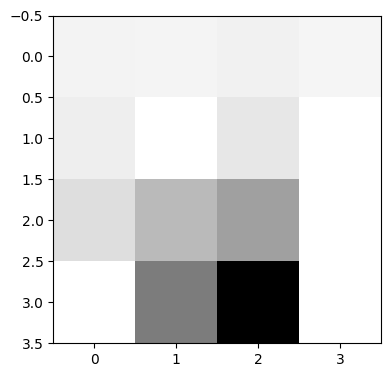

In [17]:
verbose = False
for h in vi_agent.history:
    grid = create_grid(h)
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(grid, cmap='Grays')
    plt.tight_layout()
    plt.show()
    if not verbose:
        clear_output(wait=True)
        time.sleep(1)

### Model-free agents
With model-free agents, we can appreciate the flexibility of `gym` environments when dealing with a direct exploration of the environment.

To see a simple example, we can rely on **Q-learning**.

#### Quick recap about Q-Learning
The goal of Q-learning is to learn the state-action function $Q(s, a)$ from which we can derive the optimal policy:
$$
\pi(s) = \arg\max_{a} Q(s, a)
$$

We do not have the transition probability function, so we have to explore the environment and update $Q(s, a)$ as in the following:

$$
Q_{t+1}(s, a) = (1 - \eta) Q_t(s, a) + \eta \left[ r_t + \gamma V_t(s')\right],
$$

where $\eta$ is the learning rate.

Since the state value function is just

$$
V(s) = \max_{a} Q(s, a),
$$

we actually need to compute

$$
Q_{t+1}(s, a) = (1 - \eta) Q_t(s, a) + \eta \left[ r_t + \gamma \max_{a'} Q(s', a')\right],
$$

**Note** that we explore all the possible next actions $a'$ having observed $(s, a, r, s')$, so we do not need to know which is the next action (**off-policy**).

In [18]:
class SimpleQLearningAgent:
        
    def __init__(self, env: gym.Env, gamma: float = 0.9, 
                 learning_rate: float = .01, 
                 epsilon: float = 1,
                 epsilon_decay: float = .05,
                 final_epsilon: float = .1):
        self.mdp = env 
        self.n_states = self.mdp.observation_space.n
        self.n_actions = self.mdp.action_space.n
        self.Q = np.zeros((self.n_states, self.n_actions))
        self.gamma = gamma 
        self.eta = learning_rate
        self.epsilon = epsilon
        self.e_decay = epsilon_decay
        self.e_final = final_epsilon
        self.history = []
        self.error = []
    
    def V(self, state: int):
        return np.max(self.Q[state])
    
    def e_greedy_policy(self, state: int):
        """This avoids a pure greedy choice of the next action

        Args:
            state (int): agent state
        """
        if np.random.random() < self.epsilon:
            a = self.mdp.action_space.sample() #explore
        else:
            a = int(np.argmax(self.Q[state])) #exploit
        return a

    def decay_epsilon(self):
        self.epsilon = max(self.e_final, self.epsilon - self.e_decay)

    def update_q(self, state: int, action: int, reward: float, terminated: bool, s_prime: int):
        Q_hat = (not terminated) * self.V(s_prime)
        TD = reward + self.gamma * Q_hat - self.Q[state, action]
        self.Q[state, action] += self.eta * TD
        self.error.append(TD)

    def train(self, episodes: int = 100):
        self.e_decay = self.epsilon / (episodes / 2)
        run = list(range(episodes))
        for episode in tqdm(run):
            state, info = self.mdp.reset()
            done = False
            while not done:
                action = self.e_greedy_policy(state)
                s_prime, reward, terminated, truncated, info = self.mdp.step(action)
                self.update_q(state=state, action=action, reward=reward, terminated=terminated, s_prime=s_prime)
                done = terminated or truncated 
                state = s_prime
            self.history.append([self.V(s) for s in range(self.mdp.observation_space.n)])
            self.decay_epsilon()


In [19]:
env = gym.make('FrozenLake-v1', render_mode=None, is_slippery=True)
q_learning = SimpleQLearningAgent(env=env)
q_learning.train(episodes=100_000)

  0%|          | 0/100000 [00:00<?, ?it/s]

In [20]:
def conv(a, win=100):
    return np.convolve(a, np.ones(win), mode='same') / win

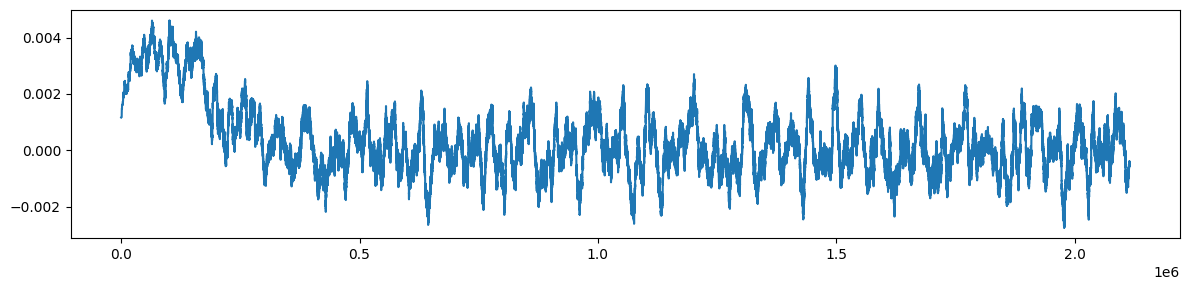

In [21]:
error_line = conv(q_learning.error, win=10000)
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(error_line)
plt.tight_layout()
plt.show()

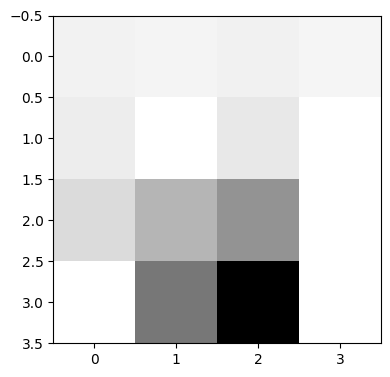

In [22]:
verbose = False
for h_index in range(0, len(q_learning.history), 1000):
    grid = create_grid(q_learning.history[h_index])
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(grid, cmap='Grays')
    plt.tight_layout()
    plt.show()
    if not verbose:
        clear_output(wait=True)
        #time.sleep(.5)

### Exploit the agent policy (greedy) to move in the environment

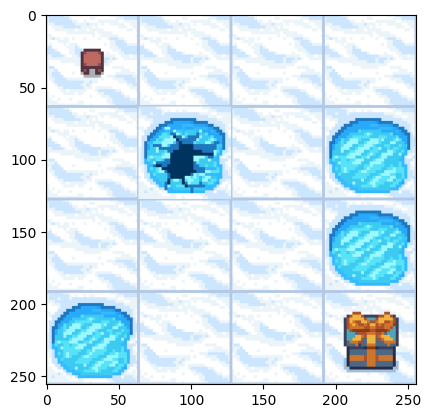

In [23]:
env = gym.make('FrozenLake-v1', render_mode='rgb_array')
state, info = env.reset()

def policy(state: int):
    action = int(np.argmax(q_learning.Q[state]))
    return action

end_episode = False 
while not end_episode:
    action = policy(state)
    s_prime, reward, terminated, truncated, info = env.step(action)
    end_episode = terminated or truncated
    clear_output(wait=True)
    plt.imshow(env.render())
    plt.show()
    time.sleep(.5)
    state = s_prime
    
env.close()


## Create custom environments
Environments in `gym` can be created by simply defining a subclass of `gym.Env` that must be registered in `gym` in order to make them initializable by the `gym.make` method.

Creating and environment requires to define a custom version of the following methods:
- `__init__()`
- `reset()`
- `step()`

In the following example, we are going to implement the following MDP Environment, called *via Conservatorio*.

In this problem, a student is traveling from *Via Conservatorio* to *Via Celoria* along a path composed by $N$ road intersection. At each intersection $s$, starting from 0, the student has three options.
1. **walk**: goes from $s$ to $s+1$ with probability 1 in $w$ minutes
2. **bus**: goas from $s$ to $s+2$
    - with probability $\beta$, this takes $b_1$ minutes
    - with probability $1 - \beta$, we need to wait for the bus, taking $b_2$ minutes
3. **metro**: goas from $s$ to $s+4$ in $x$ minutes

**Reward**
For each step, the reward is $-m$, where $m$ is the number of minutes required for travelling.

**Note**
If $s > N$ the episode ends with a additional reward of $-2b_2$.

See the complete implementation in [conservatorio](./gymbase/environments.py)

### `__init__()`
This is used to set up the enviroment and in particular, define the `observation_space`, the `action_space`, annd the transition probabilities.
```python
    def __init__(self, distance: int, beta: float = .5, 
                 walk_cost: int = 6, bus_cost: int = 4, 
                 bus_wait: int = 12, metro_cost: int = 3):
        super().__init__()
        self.N = distance
        self._agent_location = 0
        self._target_location = self.N
        self.observation_space = gym.spaces.Discrete(self.N)
        self.a2id = {'walk': 0, 'bus': 1, 'metro': 2}
        self.id2a = dict([(v, k) for k, v in self.a2id.items()])
        self.action_space = gym.spaces.Discrete(len(self.a2id))
        self.beta = beta
        self.w, self.b_1, self.b_2, self.x = walk_cost, bus_cost, bus_wait, metro_cost
```

### `reset()`
As the purpose of `reset()` is to initiate a new episode for an environment and has two parameters: `seed` and `options`. The seed can be used to initialize the random number generator to a deterministic state and options can be used to specify values used within reset.

For both `reset()` and `step()` methods it is usefull to define some utility functions for providing the next state and the info.

```python
def _get_position(self):
        return {'agent': self._agent_location, 'target': self._target_location}
    
def _get_distance(self):
    pos = self._get_position()
    return {'distance': pos['target'] - pos['agent']}

def reset(self, seed: Optional[int] = None, options: Optional[dict] = None):
    super().reset(seed=seed)
    self._agent_location = 0
    return self._agent_location, self._get_distance()
```

### `step(action)`
This is the step that returns the new state, reward, terminated or truncated, and info

```python
def step(self, action: int):
    s_prime, cost = self._move(self._agent_location, action)
    reward = -cost 
    terminated = False
    if s_prime == self.N:
        terminated = True
    elif s_prime > self.N:
        terminated = True
        reward = 2 * self.b_2
        self._agent_location = self.N
    self._agent_location = s_prime
    info = self._get_distance()
    return s_prime, reward, terminated, False, info
```

### Register the environment
```python
gym.register(
    id="Conservatorio-v0",
    entry_point=lambda distance, beta, walk_cost, bus_cost, bus_wait, metro_cost: 
    Conservatorio(distance, beta, walk_cost, bus_cost, bus_wait, metro_cost),
    max_episode_steps=300,
)
```

In [24]:
import gymbase.environments

In [25]:
env = gym.make('Conservatorio-v0', distance=20, beta=.6, walk_cost=6, bus_cost=4, bus_wait=12, metro_cost=3)

In [26]:
state, info = env.reset()
print(state, info)

0 {'distance': 20}


In [24]:
done = False 
state, info = env.reset()
total_return = 0

while not done:
    action = env.action_space.sample()
    s_prime, reward, terminated, truncated, info = env.step(action)
    total_return += reward
    done = terminated or truncated
    print(f"agent pos: {state} moving to {s_prime} by {env.unwrapped.id2a[action]} with cost {reward}")
    state = s_prime
env.close()
print(f"Total cost: {total_return}")


agent pos: 0 moving to 4 by metro with cost -3
agent pos: 4 moving to 5 by walk with cost -6
agent pos: 5 moving to 6 by walk with cost -6
agent pos: 6 moving to 7 by walk with cost -6
agent pos: 7 moving to 11 by metro with cost -3
agent pos: 11 moving to 12 by walk with cost -6
agent pos: 12 moving to 14 by bus with cost -4
agent pos: 14 moving to 18 by metro with cost -3
agent pos: 18 moving to 20 by bus with cost -12
Total cost: -49


## Wrappers
Wrappers are classes that overrides enviroment by adding further functionalities. They are useful for several tasks, including recording the environment behavior.

In [27]:
from gymnasium.wrappers import RecordEpisodeStatistics

In [28]:
num_eval_episodes = 4
env = gym.make('Conservatorio-v0', distance=20, beta=.6, walk_cost=6, bus_cost=4, bus_wait=12, metro_cost=3)
env = RecordEpisodeStatistics(env, buffer_length=num_eval_episodes)

for episode_num in range(num_eval_episodes):
    done = False 
    state, info = env.reset()
    total_return = 0

    while not done:
        action = env.action_space.sample()
        s_prime, reward, terminated, truncated, info = env.step(action)
        total_return += reward
        done = terminated or truncated
        state = s_prime
    env.close()

print(f'Episode time taken: {env.time_queue}')
print(f'Episode total rewards: {env.return_queue}')
print(f'Episode lengths: {env.length_queue}')

Episode time taken: deque([0.001478, 5.4e-05, 3.9e-05, 4.7e-05], maxlen=4)
Episode total rewards: deque([-7.0, -32.0, -19.0, -32.0], maxlen=4)
Episode lengths: deque([8, 11, 9, 11], maxlen=4)


For an example on how to record a video, see [video.py](./gymbase/video.py)